In [1]:
import pandas as pd 
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import tensorflow as tf
from tensorflow.keras import layers

2024-10-21 19:29:56.792164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 19:29:56.809865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 19:29:56.814908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 19:29:56.828492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 19:29:57.527125: W tensorflow/compiler/tf2

In [2]:
data_path = './dataset_1/train'
wavs_path = data_path + '/audio/'
transcript_path = data_path + '/transcription.txt'

In [3]:
with open(transcript_path, 'r', encoding='utf-8') as file:
    data = file.read()

In [4]:
file_names = []
transcriptions = []

with open(transcript_path, 'r', encoding='utf-8') as file:
    data = file.readlines()

for line in data:
    line = line.strip()  
    if line: 
        parts = line.split(maxsplit=1) 
        if len(parts) == 2:
            file_names.append(parts[0])
            transcriptions.append(parts[1])

df = pd.DataFrame({
    'file_name': file_names,
    'transcription': transcriptions
})

print(df)
df.to_csv(data_path + 'transcriptions.csv', index=False, encoding='utf-8-sig')

      file_name                           transcription
0      0001_030                         यह है मोटा राजा
1      0001_043                         यह है मोटा राजा
2      0002_002            मोटे राजा का है दुबला कुत्ता
3      0002_019            मोटे राजा का है दुबला कुत्ता
4      0002_039            मोटे राजा का है दुबला कुत्ता
...         ...                                     ...
99920  6049_047  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा
99921  6049_050  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा
99922  6049_078  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा
99923  6049_080  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा
99924  6049_097  हम बुलबुलें हैं इसकी यह गुलसिताँ हमारा

[99925 rows x 2 columns]


In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,file_name,transcription
0,5314_047,कुछ याद उन्हें भी कर लो
1,3421_057,महानाविक ने कभी यह रूप न देखा था
2,3473_027,प्रकृति की सहृदय कल्पना विश्राम की शीतल छाया
3,3645_077,के लिए पोरबंदर से राजकोट ले आए
4,5904_050,हम भी बनिये के बच्चे हैं ऐसे बुद्धू कहीं और होंगे


In [6]:
split = int(len(df)*0.9)
df_train=df[:split]
df_val=df[split:]
print(f"Size of the training set : {len(df_train)}")
print(f"Size of the validation set : {len(df_val)}")

Size of the training set : 89932
Size of the validation set : 9993


# Preprocessing

In [7]:
import numpy as np
from tensorflow import keras

characters = sorted(set("अआइईउऊऋएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसहाि ी ु ू ृ े ै ो ौ ं ः ् ँ०१२३४५६७८९'?!। "))

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)
print(f"The vocabulary size is : {char_to_num.get_vocabulary()}")
print(f"size = : {char_to_num.vocabulary_size()}")

The vocabulary size is : ['', ' ', '!', "'", '?', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ो', 'ौ', '्', '।', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९']
size = : 74


I0000 00:00:1729519198.923120  150354 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-21 19:29:58.973767: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
frame_length=256
frame_step=160
fft_length=384

In [9]:
def encode_single_sample(wav_file, label):
    file=tf.io.read_file(wavs_path+wav_file+".wav")
    audio,_=tf.audio.decode_wav(file)
    audio=tf.squeeze(audio, axis=-1)
    audio=tf.cast(audio, tf.float32)
    spectogram=tf.signal.stft(audio,frame_length=frame_length,frame_step=frame_step,fft_length=fft_length)
    spectogram=tf.abs(spectogram)
    spectogram=tf.math.pow(spectogram, 0.5)
    means=tf.math.reduce_mean(spectogram,1,keepdims=True)
    stddevs=tf.math.reduce_std(spectogram,1,keepdims=True)
    spectogram=(spectogram-means)/(stddevs + 1e-10)
    label=tf.strings.lower(label)
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=char_to_num(label)
    return spectogram, label

In [10]:
batch_size=16

train_dataset=tf.data.Dataset.from_tensor_slices((list(df_train['file_name']), list(df_train['transcription'])))
train_dataset=(train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))


val_dataset=tf.data.Dataset.from_tensor_slices((list(df_val['file_name']), list(df_val['transcription'])))
val_dataset=(val_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

2024-10-21 19:30:00.021891: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/money_heist_435601/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/money_heist_435601/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/money_heist_435601/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/money_heist_435601/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2331 (\N{DEVANAGARI LETTER CHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print

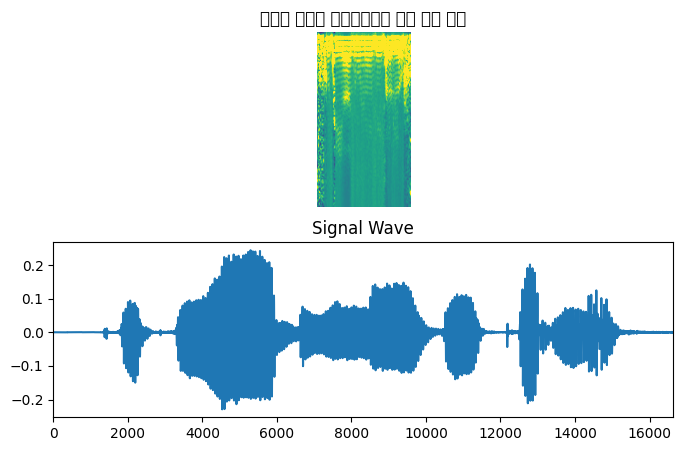

In [11]:
fig=plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
    spectogram=batch[0][0].numpy()
    spectogram=np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
    label=batch[1][0]

    label=tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax=plt.subplot(2,1,1)
    ax.imshow(spectogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    file=tf.io.read_file(wavs_path+list(df_train["file_name"])[0]+".wav")
    audio,_=tf.audio.decode_wav(file)
    audio=audio.numpy()
    ax=plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()


# Model

In [12]:
def CTCLoss(y_true, y_pred):
    batch_len=tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length=tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length=tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length=input_length*tf.ones(shape=(batch_len,1),dtype="int64")
    label_length=label_length*tf.ones(shape=(batch_len,1),dtype="int64")

    loss=keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [13]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    input_spectogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectogram)
    
    x = layers.Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding='same', use_bias=False, name="conv_1")(x)
    x = layers.BatchNormalization(name='conv_1_bn')(x)
    x = layers.ReLU(name='conv_1_relu')(x)

    x = layers.Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding='same', use_bias=False, name="conv_2")(x)
    x = layers.BatchNormalization(name='conv_2_bn')(x)
    x = layers.ReLU(name='conv_2_relu')(x)

    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units=rnn_units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=True, reset_after=True, name=f"gru_{i}")
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode='concat')(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    x = layers.Dense(units=rnn_units * 2, name='dense_1')(x)
    x = layers.ReLU(name='dense_1_relu')(x)
    x = layers.Dropout(rate=0.5)(x)

    output = layers.Dense(units=output_dim + 1, activation='softmax', name='dense_output')(x)
    model = keras.Model(input_spectogram, output, name='DeepSpeech2')
    opt = keras.optimizers.Adam(learning_rate=1e-4)  # Corrected line
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


In [14]:
model=build_model(input_dim=fft_length//2+1, output_dim=char_to_num.vocabulary_size(), rnn_units=512,)
model.summary(line_length=110)

Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,672,555 (101.75 MB)

 Trainable params: 26,672,427 (101.75 MB)

 Non-trainable params: 128 (512.00 B)

# Training

In [15]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [16]:
class CallbackEval(keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
    def on_epoch_end(self, epoch: int, logs=None):
        predictions=[]
        targets=[]
        for batch in self.dataset:
            X,y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("*"*100)
        print(f"Word Error Rate : {wer_score:.4f}")
        print("*"*100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target : {targets[i]}")
            print(f"Prediction : {predictions[i]}")
            print("*"*100)

In [17]:
epochs = 1
validation_callback = CallbackEval(val_dataset)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

   5/5621 ━━━━━━━━━━━━━━━━━━━━ 20:39:25 13s/step - loss: 420.3858

2024-10-21 19:31:16.046808: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 19:31:16.047020: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 19:31:16.047098: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 19:31:16.047135: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 19:31:16.047489: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


  25/5621 ━━━━━━━━━━━━━━━━━━━━ 19:53:51 13s/step - loss: inf

2024-10-21 19:35:30.048352: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


  88/5621 ━━━━━━━━━━━━━━━━━━━━ 19:23:17 13s/step - loss: inf

2024-10-21 19:48:40.822055: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 19:48:40.822274: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 190/5621 ━━━━━━━━━━━━━━━━━━━━ 18:25:35 12s/step - loss: inf

2024-10-21 20:08:51.269125: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 20:08:51.269185: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 20:08:51.269463: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 249/5621 ━━━━━━━━━━━━━━━━━━━━ 17:57:14 12s/step - loss: inf

2024-10-21 20:20:06.777163: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 272/5621 ━━━━━━━━━━━━━━━━━━━━ 17:47:26 12s/step - loss: inf

2024-10-21 20:24:27.679817: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 20:24:27.679873: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 20:24:27.680292: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 418/5621 ━━━━━━━━━━━━━━━━━━━━ 17:30:06 12s/step - loss: inf

2024-10-21 20:54:32.685137: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 498/5621 ━━━━━━━━━━━━━━━━━━━━ 17:14:51 12s/step - loss: inf

2024-10-21 21:10:46.839277: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:10:46.839347: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:10:46.839507: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 499/5621 ━━━━━━━━━━━━━━━━━━━━ 17:14:37 12s/step - loss: inf

2024-10-21 21:10:58.809435: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:10:58.809517: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:10:58.809589: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:10:58.809620: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:10:58.809780: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:10:58.809859: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 506/5621 ━━━━━━━━━━━━━━━━━━━━ 17:12:21 12s/step - loss: inf

2024-10-21 21:12:18.382637: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:12:18.382709: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:12:18.382763: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:12:18.382827: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:12:18.382844: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 567/5621 ━━━━━━━━━━━━━━━━━━━━ 16:57:28 12s/step - loss: inf

2024-10-21 21:24:20.142747: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:24:20.142812: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:24:20.142873: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:24:20.142983: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:24:20.143011: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:24:20.143353: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 626/5621 ━━━━━━━━━━━━━━━━━━━━ 16:45:42 12s/step - loss: inf

2024-10-21 21:36:13.133019: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:36:13.133077: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:36:13.133125: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:36:13.133149: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:36:13.133173: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:36:13.133193: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:36:13.133213: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:36:13.133580: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:36:13.133627: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 709/5621 ━━━━━━━━━━━━━━━━━━━━ 16:25:01 12s/step - loss: inf

2024-10-21 21:52:21.608529: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:52:21.608633: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 21:52:21.608725: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 865/5621 ━━━━━━━━━━━━━━━━━━━━ 15:47:27 12s/step - loss: inf

2024-10-21 22:22:29.854682: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 966/5621 ━━━━━━━━━━━━━━━━━━━━ 15:22:39 12s/step - loss: inf

2024-10-21 22:41:39.134972: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 22:41:39.135049: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


 991/5621 ━━━━━━━━━━━━━━━━━━━━ 15:17:35 12s/step - loss: inf

2024-10-21 22:46:34.789105: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 22:46:34.789187: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 22:46:34.789210: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 22:46:34.789271: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 22:46:34.789299: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 22:46:34.789324: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 22:46:34.789352: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 22:46:34.789368: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 22:46:34.789391: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1231/5621 ━━━━━━━━━━━━━━━━━━━━ 14:30:14 12s/step - loss: inf

2024-10-21 23:34:12.312528: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1244/5621 ━━━━━━━━━━━━━━━━━━━━ 14:27:03 12s/step - loss: inf

2024-10-21 23:36:36.588822: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 23:36:36.588953: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 23:36:36.588974: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 23:36:36.589002: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 23:36:36.589020: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 23:36:36.589067: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 23:36:36.589088: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-21 23:36:36.589109: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1451/5621 ━━━━━━━━━━━━━━━━━━━━ 13:41:41 12s/step - loss: inf

2024-10-22 00:16:06.025127: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1651/5621 ━━━━━━━━━━━━━━━━━━━━ 13:00:53 12s/step - loss: inf

2024-10-22 00:55:18.950262: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 560697984 exceeds 10% of free system memory.
2024-10-22 00:55:18.950306: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 560697984 exceeds 10% of free system memory.


2045/5621 ━━━━━━━━━━━━━━━━━━━━ 11:43:16 12s/step - loss: inf

2024-10-22 02:12:21.781695: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2296/5621 ━━━━━━━━━━━━━━━━━━━━ 10:52:45 12s/step - loss: inf

2024-10-22 03:00:55.957471: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:00:55.957566: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:00:55.957615: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:00:55.957930: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2441/5621 ━━━━━━━━━━━━━━━━━━━━ 10:23:24 12s/step - loss: inf

2024-10-22 03:28:42.801098: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:28:42.801168: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:28:42.801192: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:28:42.801214: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:28:42.801239: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:28:42.801263: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:28:42.801310: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:28:42.801332: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:28:42.801354: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 03:28:42.801379: W ./tensorflow/core/util/ct

2550/5621 ━━━━━━━━━━━━━━━━━━━━ 10:01:51 12s/step - loss: inf

2024-10-22 03:49:56.652965: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2897/5621 ━━━━━━━━━━━━━━━━━━━━ 8:51:49 12s/step - loss: inf

2024-10-22 04:55:47.373191: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2910/5621 ━━━━━━━━━━━━━━━━━━━━ 8:49:03 12s/step - loss: inf

2024-10-22 04:58:05.200175: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 04:58:05.200313: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 04:58:05.200406: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 04:58:05.200462: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 04:58:05.200490: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 04:58:05.200605: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


2951/5621 ━━━━━━━━━━━━━━━━━━━━ 8:41:08 12s/step - loss: inf

2024-10-22 05:06:10.733323: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 05:06:10.733518: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 05:06:10.733574: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 05:06:10.733633: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 05:06:10.733783: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 05:06:10.733805: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 05:06:10.733845: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 05:06:10.733864: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 05:06:10.733888: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 05:06:10.733913: W ./tensorflow/core/util/ct

3041/5621 ━━━━━━━━━━━━━━━━━━━━ 8:23:11 12s/step - loss: inf

2024-10-22 05:23:17.779390: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3333/5621 ━━━━━━━━━━━━━━━━━━━━ 7:25:41 12s/step - loss: inf

2024-10-22 06:19:25.753459: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3471/5621 ━━━━━━━━━━━━━━━━━━━━ 6:58:32 12s/step - loss: inf

2024-10-22 06:45:53.911494: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3780/5621 ━━━━━━━━━━━━━━━━━━━━ 5:58:16 12s/step - loss: inf

2024-10-22 07:45:48.980984: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 07:45:48.981289: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 07:45:48.981378: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 07:45:48.981428: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 07:45:48.981477: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3789/5621 ━━━━━━━━━━━━━━━━━━━━ 5:56:31 12s/step - loss: inf

2024-10-22 07:47:35.041918: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 07:47:35.041999: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


3983/5621 ━━━━━━━━━━━━━━━━━━━━ 5:18:43 12s/step - loss: inf

2024-10-22 08:25:11.828161: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 08:25:11.828219: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 08:25:11.828270: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 08:25:11.828302: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


4124/5621 ━━━━━━━━━━━━━━━━━━━━ 4:50:57 12s/step - loss: inf

2024-10-22 08:51:43.183590: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 08:51:43.183786: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 08:51:43.183833: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


4223/5621 ━━━━━━━━━━━━━━━━━━━━ 4:31:40 12s/step - loss: inf

2024-10-22 09:10:49.655597: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 09:10:49.655682: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 09:10:49.655712: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 09:10:49.655764: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 09:10:49.655791: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 09:10:49.655813: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 09:10:49.655836: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 09:10:49.655858: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 09:10:49.655881: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 09:10:49.655904: W ./tensorflow/core/util/ct

4259/5621 ━━━━━━━━━━━━━━━━━━━━ 4:24:35 12s/step - loss: inf

2024-10-22 09:17:54.938942: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 538965504 exceeds 10% of free system memory.
2024-10-22 09:17:54.938989: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 538965504 exceeds 10% of free system memory.


4275/5621 ━━━━━━━━━━━━━━━━━━━━ 4:21:34 12s/step - loss: inf

2024-10-22 09:20:58.776749: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


4512/5621 ━━━━━━━━━━━━━━━━━━━━ 3:35:31 12s/step - loss: inf

2024-10-22 10:07:03.261004: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 10:07:03.261062: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 10:07:03.261085: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


4566/5621 ━━━━━━━━━━━━━━━━━━━━ 3:24:58 12s/step - loss: inf

2024-10-22 10:17:19.797100: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


5508/5621 ━━━━━━━━━━━━━━━━━━━━ 21:57 12s/step - loss: inf

2024-10-22 13:20:10.743846: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


5621/5621 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: inf 

2024-10-22 13:42:31.218112: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 13:42:42.505724: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 13:43:06.443698: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 13:52:36.721918: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 13:52:36.722112: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 13:52:36.722147: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 13:52:36.722164: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2024-10-22 13:54:14.669548: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━

2024-10-22 14:10:18.173094: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


****************************************************************************************************
Word Error Rate : 0.8608
****************************************************************************************************
Target : की सहानुभूति और सेवा के लिए
Prediction : की सहानो मो मु व से वआाती मं
****************************************************************************************************
Target : जुम्मन बोलेयह दूसरा सवाल है
Prediction : जुमन बोले य दोसला सवाल है
****************************************************************************************************
5621/5621 ━━━━━━━━━━━━━━━━━━━━ 67217s 12s/step - loss: inf - val_loss: inf


In [18]:
predictions = []
targets = []
for batch in val_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━

## Additional


In [20]:
import random
import IPython.display as ipd

def test_random_sample_with_audio(model, dataset, num_samples=5):
    val_samples = list(dataset.unbatch().take(num_samples))
    
    random.shuffle(val_samples)
    
    for X, y in val_samples:
        batch_prediction = model.predict(tf.expand_dims(X, axis=0))
        batch_prediction_decoded = decode_batch_predictions(batch_prediction)[0]
        
        target_label = tf.strings.reduce_join(num_to_char(y)).numpy().decode("utf-8")
        
        spectrogram, _ = X.numpy(), y.numpy()
        
        audio_file_name = df_val[df_val['transcription'] == target_label]['file_name'].values[0]
        audio_path = wavs_path + audio_file_name + ".wav"
        
        print(f"Playing audio for file: {audio_file_name}")
        ipd.display(ipd.Audio(audio_path))

        print("*" * 100)
        print(f"Original Transcription  : {target_label}")
        print(f"Predicted Transcription : {batch_prediction_decoded}")
        print("*" * 100)
        print("\n\n")

test_random_sample_with_audio(model, val_dataset, num_samples=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
Playing audio for file: 3714_067


****************************************************************************************************
Original Transcription  : में काम करने का प्रस्ताव मिला
Predicted Transcription : मैं कामकरमे का परसा हुा
****************************************************************************************************



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
Playing audio for file: 4131_046


****************************************************************************************************
Original Transcription  : इसलिए हमेशा सकारात्मक बोलें
Predicted Transcription : इिसली आमसा सका रासम बोले
****************************************************************************************************



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Playing audio for file: 2887_064


****************************************************************************************************
Original Transcription  : फिर झटसे उठ बैठा
Predicted Transcription : से ज सी उुत लेता
****************************************************************************************************



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Playing audio for file: 3967_034


****************************************************************************************************
Original Transcription  : श्वेत क्रांति के जनक माने जाने वाले इस शख्स ने
Predicted Transcription : वे कराकी के जनकमाने जाने वाले इसस स
****************************************************************************************************



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Playing audio for file: 2207_024


****************************************************************************************************
Original Transcription  : हताश निराश नन्ही सी मीनू जब घर पहुंची तो उसके आंसुओं की वजह से
Predicted Transcription : सा तमिया मनी ी मीनों ज पर मोकी तोके आसम की वज े
****************************************************************************************************



